In [1]:
import re
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import QuantileTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split


# from google.colab import drive

In [ ]:
# для работы в колабе

drive.mount('/data')
path = '/data/MyDrive/DS & ML/баловство/HH_ pet_project_03_01_24/data/cleaned_hh_data_for_modelling_49k.csv'
data = pd.read_csv(path)
data.head()

In [ ]:
# для локального запуска

data = pd.read_csv('data/cleaned_hh_data_for_modelling_46k.csv')

## Подготовка данных

### Таргет

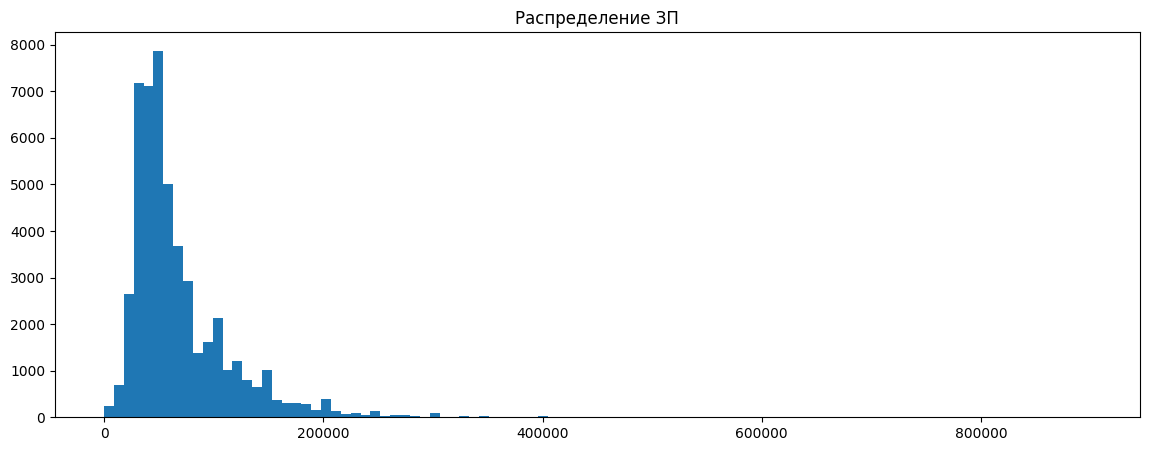

In [ ]:
fig, ax= plt.subplots(figsize=(14,5))
ax.hist(data['salary'], bins=100)
ax.set_title('Распределение ЗП');

Как и ожидалось (низких зарплат обычно больше), распределение таргета похоже на логнормальное или гамма, поэтому для обучения и получения предсказаний проведу логарифмирование переменной.\
Также избавлюсь от аномально высоких значений и значений, близких к 0.

upd. поскольку голарифмирование не дало ожидаемого результата, я также протестировал несколько других трансформаций.\
Наилучшего результата удалось добиться благодаря QuantileTransformer.

In [ ]:
data = data.query('5000 < salary < 200000')

In [ ]:
data['log_salary'] = np.log(data['salary'])

In [ ]:
quantile = QuantileTransformer(output_distribution='normal')
data['q_salary'] = quantile.fit_transform(data['salary'].values.reshape((len(data),1)))

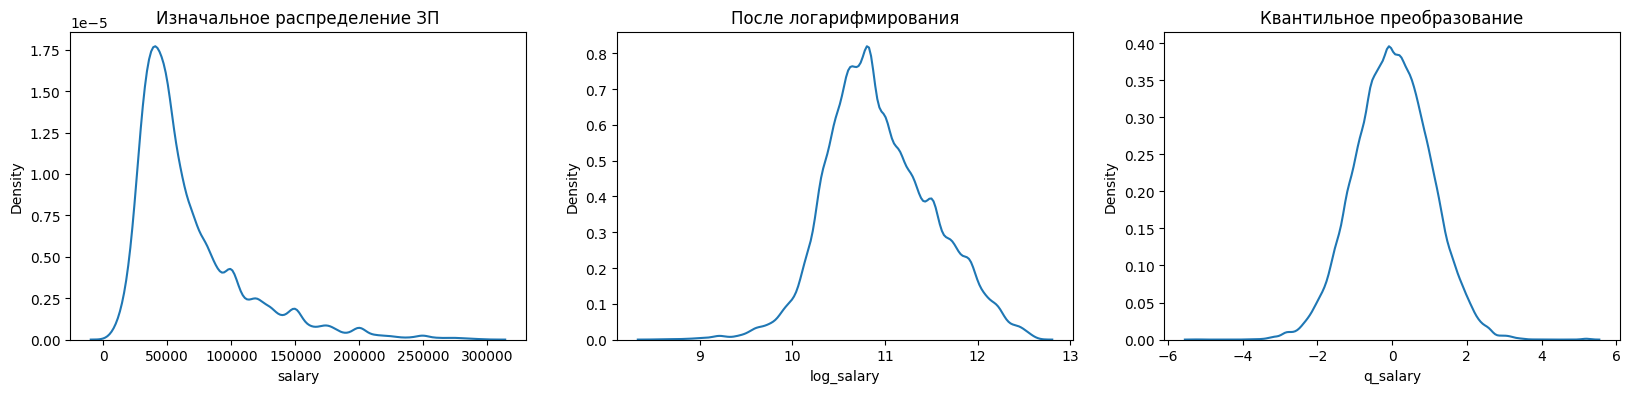

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 4))
original_y = sns.kdeplot(data['salary'], ax=axes[0])
original_y.set_title('Изначальное распределение ЗП')
log_y = sns.kdeplot(data['log_salary'], ax=axes[1])
log_y.set_title('После логарифмирования')
qt_y = sns.kdeplot(data['q_salary'])
qt_y.set_title('Квантильное преобразование');

### Подготовка текста для анализа описания вакансий

In [ ]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^А-Яа-яA-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df

data = standardize_text(data, "description")

data.head()

<ipython-input-12-8c1515ab97b2>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df[text_field] = df[text_field].str.replace(r"http\S+", "")
<ipython-input-12-8c1515ab97b2>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df[text_field] = df[text_field].str.replace(r"@\S+", "")
<ipython-input-12-8c1515ab97b2>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df[text_field] = df[text_field].str.replace(r"[^А-Яа-яA-Za-z0-9(),!?@\'\`\"\_\n]", " ")


,id,title,description,compensation_type,salary,log_salary,q_salary
0,88005041,Оператор 1C,обязанности мы ищем сотрудника способного ра...,на руки,40000.0,10.596635,-0.564267
1,89427852,Инженер связи,простор телеком представлен на рынке телекомму...,на руки,60000.0,11.002100,0.223916
2,88891879,Редактор текстов в интернет-агентство,"привет! меня зовут станислав, я руководитель к...",на руки,20000.0,9.903488,-1.994971
3,88559265,Электрик-электронщик,обязанности обслуживание станков с чпу тр...,на руки,80000.0,11.289782,0.659602
4,89688196,Руководитель филиала,"лизинговая компания ""смарт лизинг"" предлагает ...",до вычета налогов,217500.0,12.289954,2.326637


In [ ]:
!python -m spacy download ru_core_news_sm

import spacy
ru_spacy = spacy.load("ru_core_news_sm")

In [ ]:
def lemmatize_text(text):
    doc = ru_spacy(text)
    lemmatized_text = " ".join([token.lemma_ for token in doc])
    print(lemmatized_text)
    return lemmatized_text

In [ ]:
data['description'] = data['description'].apply(lambda x: str(x))

In [ ]:
data['lem_desc'] = data['description'].apply(lambda x: lemmatize_text(x))
data.head()

Сохраню даанные в файл, чтобы сохранить результат и не производить лемматизацию повторно.

In [ ]:
# для работы в google.colab

drive.mount('/data')
path = '/data/MyDrive/DS & ML/баловство/HH_ pet_project_03_01_24/data/hh_lemmatized.csv'
data.to_csv(path, index=False)

Drive already mounted at /data; to attempt to forcibly remount, call drive.mount("/data", force_remount=True).


In [ ]:
# для работы в google.colab

drive.mount('/data')
path = '/data/MyDrive/DS & ML/баловство/HH_ pet_project_03_01_24/data/hh_lemmatized.csv'
lem_data = pd.read_csv(path)
lem_data.head()

Mounted at /data


,id,title,description,compensation_type,salary,log_salary,q_salary,lem_desc
0,88005041,Оператор 1C,обязанности мы ищем сотрудника способного ра...,на руки,40000.0,10.596635,-0.564267,обязанность мы искать сотрудник способный р...
1,89427852,Инженер связи,простор телеком представлен на рынке телекомму...,на руки,60000.0,11.002100,0.223916,простор телек представить на рынок телекоммуни...
2,88891879,Редактор текстов в интернет-агентство,"привет! меня зовут станислав, я руководитель к...",на руки,20000.0,9.903488,-1.994971,"привет ! меня звать станислав , я руководитель..."
3,88559265,Электрик-электронщик,обязанности обслуживание станков с чпу тр...,на руки,80000.0,11.289782,0.659602,обязанность обслуживание станок с чпу т...
4,89688196,Руководитель филиала,"лизинговая компания ""смарт лизинг"" предлагает ...",до вычета налогов,217500.0,12.289954,2.326637,"лизинговый компания "" смарт лизинг "" предлагат..."


In [2]:
lem_data = pd.read_csv('data/hh_lemmatized.csv')

In [8]:
lem_data = lem_data.dropna()
lem_data.reset_index(inplace=True)

In [9]:
lem_data['lem_desc'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 48283 entries, 0 to 48282
Series name: lem_desc
Non-Null Count  Dtype 
--------------  ----- 
48283 non-null  object
dtypes: object(1)
memory usage: 377.3+ KB


## Modelling

### Title

In [10]:
title = lem_data['title']
desc = lem_data['lem_desc']
y = lem_data['salary']

In [11]:
tX_train, tX_test, y_train, y_test = train_test_split(title, y)
dX_train, dX_test, y_train, y_test = train_test_split(desc, y)

In [12]:
tfidf_title = TfidfVectorizer()
X_train_title = tfidf_title.fit_transform(tX_train)
X_test_title = tfidf_title.transform(tX_test)

In [13]:
sgd_title = SGDRegressor(random_state=42,
                         max_iter=100
                         )

sgd_title.fit(X_train_title, y_train)

title_train_pred = sgd_title.predict(X_train_title)
title_test_pred = sgd_title.predict(X_test_title)

/home/roman/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:1561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


In [14]:
print('MAE tfidf train:', mean_absolute_error(y_train, title_train_pred))
print('MAE tfidf test:', mean_absolute_error(y_test, title_test_pred))

MAE tfidf train: 27437.04739973697
MAE tfidf test: 28308.363422217128


### Description

In [15]:
tfidf_desc = TfidfVectorizer()
X_train_desc = tfidf_desc.fit_transform(dX_train)
X_test_desc = tfidf_desc.transform(dX_test)

In [16]:
sgd_desc = SGDRegressor(random_state=42,
                         max_iter=100
                         )

sgd_desc.fit(X_train_desc, y_train)

desc_train_pred = sgd_desc.predict(X_train_desc)
desc_test_pred = sgd_desc.predict(X_test_desc)

/home/roman/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:1561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


In [17]:

print('MAE tfidf train:', mean_absolute_error(y_train, desc_train_pred))
print('MAE tfidf test:', mean_absolute_error(y_test, desc_test_pred))

MAE tfidf train: 18446.804267152787
MAE tfidf test: 18955.833938910426


MAE tfidf train: 21266.19954101879 \
MAE tfidf test: 22220.073728659634

target<200k: \
MAE tfidf train: 18871.705655911508 \
MAE tfidf test: 19398.271728154705

+10k objects (46k): \
MAE tfidf train: 18462.959139707622 \
MAE tfidf test: 19026.831634274222

In [18]:
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_desc, y_train)
desc_pred_train = rf.predict(X_train_desc)
desc_pred_test = rf.predict(X_test_desc)

In [20]:
print('MAE tfidf train:', mean_absolute_error(y_train, desc_pred_train))
print('MAE tfidf test:', mean_absolute_error(y_test, desc_pred_test))

MAE tfidf train: 15478.570659438214
MAE tfidf test: 18781.339418977917


MAE tfidf train: 18547.573341756815 \
MAE tfidf test: 21980.729619577924

target<200k: \
MAE tfidf train: 16527.412374244534 \
MAE tfidf test: 19120.248718578816

+10k objects (46k): \
MAE tfidf train: 16356.895357263895 \
MAE tfidf test: 19002.617410408533

### target tranformation

In [21]:
quantile = QuantileTransformer(output_distribution='normal')
q_y_train = quantile.fit_transform(y_train.values.reshape((len(y_train),1)))
q_y_test = quantile.transform(y_test.values.reshape((len(y_test),1)))

In [22]:
sgd_desc = SGDRegressor(random_state=42,
                         max_iter=100
                         )

sgd_desc.fit(X_train_desc, q_y_train)

desc_train_pred = sgd_desc.predict(X_train_desc)
desc_test_pred = sgd_desc.predict(X_test_desc)

/home/roman/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [23]:
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_desc, q_y_train)
desc_train_pred = rf.predict(X_train_desc)
desc_test_pred = rf.predict(X_test_desc)

/home/roman/.local/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


KeyboardInterrupt: 

In [26]:
gbr = GradientBoostingRegressor(
    n_estimators=200,
    max_depth=5,
    min_samples_leaf=6,
    random_state=42
)

gbr.fit(X_train_desc, q_y_train)
desc_train_pred = gbr.predict(X_train_desc)
desc_test_pred = gbr.predict(X_test_desc)

/home/roman/.local/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [84]:
desc_train_pred_series = pd.Series(desc_train_pred).values.reshape((len(y_train),1))
desc_test_pred_series = pd.Series(desc_test_pred).values.reshape((len(y_test),1))

In [85]:
inversed_desc_train_pred = quantile.inverse_transform(desc_train_pred_series)
inversed_desc_test_pred = quantile.inverse_transform(desc_test_pred_series)

In [86]:
print('MAE tfidf train:', mean_absolute_error(y_train, inversed_desc_train_pred))
print('MAE tfidf test:', mean_absolute_error(y_test, inversed_desc_test_pred))

MAE tfidf train: 15707.80035333802
MAE tfidf test: 17586.746154225122


## Метрики:

SGD: \
   MAE tfidf train: 18493.41649841718 \
   MAE tfidf test: 18684.21683400082
   

RF:\
   MAE tfidf train: 14438.617433107207 \
   MAE tfidf test: 17811.899034571044

GB: \
   MAE tfidf train: 15565.226420526447 \
   MAE tfidf test: 17311.503140920242

In [87]:
# даю один пример модели

print(y_test.iloc[42], inversed_desc_test_pred[42])

39150.0 [69644.76234492]


In [88]:
inversed_desc_train_pred = pd.DataFrame(inversed_desc_train_pred)

In [89]:
train_residuals = y_train - inversed_desc_train_pred.iloc[:,0]

In [90]:
train_residuals = pd.DataFrame(train_residuals)
train_residuals['predict'] = inversed_desc_train_pred
train_residuals['y_train'] = y_train

In [94]:
train_residuals.dropna(how='any', inplace=True)

In [95]:
train_residuals

,0,y_train,predict
1,10000.000000,60000.0,50000.000000
2,-25000.000000,20000.0,45000.000000
3,35988.412031,80000.0,44011.587969
4,-7153.831886,35000.0,42153.831886
7,37500.000000,90000.0,52500.000000
...,...,...,...
36203,-19600.000000,50000.0,69600.000000
36206,4700.000000,52200.0,47500.000000
36208,-53900.000000,26100.0,80000.000000
36209,12501.610980,43500.0,30998.389020


<Axes: xlabel='0', ylabel='Count'>

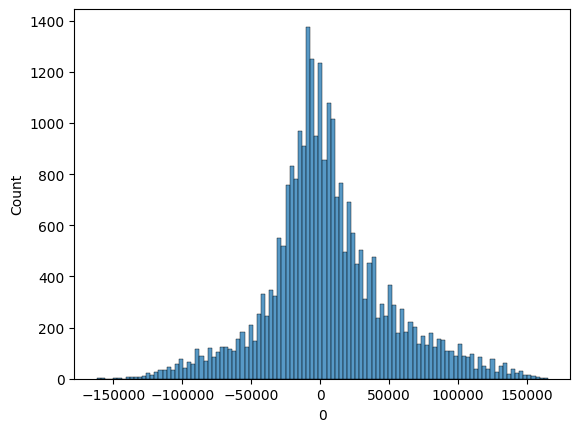

In [96]:
sns.histplot(train_residuals[0])

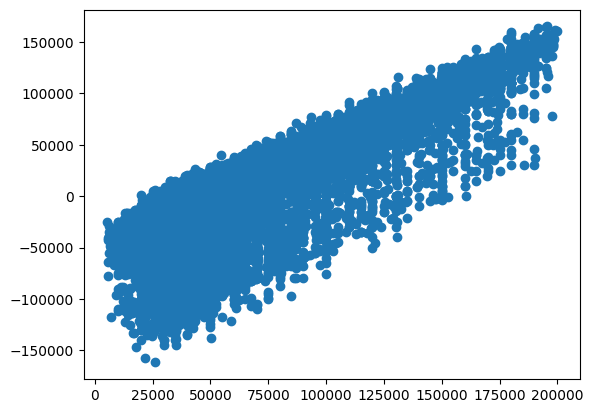

In [113]:
# распределение ошибок относительно значения таргета
plt.scatter(train_residuals['y_train'], train_residuals[0])